Comment prédire le podium d'une course de Formule Un ? 

Librairies : 

In [1]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt


Chargement des données : 

In [26]:
drivers = pd.read_csv(os.path.join("donnees_formule_un", "drivers.csv")\
    , on_bad_lines='skip')
drivers.columns = drivers.columns.str.strip()
drivers["forename"] = drivers["forename"].str.replace('"', '').str.strip()
drivers["surname"] = drivers["surname"].str.replace('"', '').str.strip()
drivers["nom_complet"] = drivers["forename"] + " " + drivers["surname"]

constructors = pd.read_csv(os.path.join("donnees_formule_un", "constructors.csv"))
constructors.columns = constructors.columns.str.strip()

results = pd.read_csv(os.path.join("donnees_formule_un", "results.csv"))
results.columns = results.columns.str.strip()

races = pd.read_csv(os.path.join("donnees_formule_un", "races.csv"))
races.columns = races.columns.str.strip()
constructor_standings = pd.read_csv(os.path.join("donnees_formule_un", "constructor_standings.csv"))
constructor_standings.columns = constructor_standings.columns.str.strip()

"""qualifying = pd.read_csv(os.path.join("donnees_formule_un", "qualifying.csv"))
qualifying.columns = qualifying.columns.str.strip()"""

print("drivers")
print(drivers.columns)
print("construtors")
print(constructors.columns)
print("races")
print(races.columns)
print("results")
print(results.columns)
print("constructor_standings")
print(constructor_standings.columns)
"""print("qualifying")
print(qualifying.columns)"""

drivers
Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url', 'nom_complet'],
      dtype='object')
construtors
Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
races
Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')
results
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')
constructor_standings
Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')


'print("qualifying")\nprint(qualifying.columns)'

Table énorme 

In [98]:
table_1 = pd.merge(races, results, on= "raceId")
table_2 = pd.merge(table_1, constructors, on = "constructorId")
table = pd.merge(table_2, drivers, on = "driverId")


print(table.columns)
#sélectionner les variables dans la table
table = table[['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder', 'grid']]

# table triée sur les années 2023 et 2024 :
df = table[(table['year'] == 2023) | (table['year'] == 2024)]
df = df.drop_duplicates(subset=['raceId', 'nom_complet']) # éviter les doublons
print(df.head())


Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_y',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'constructorRef', 'name_y',
       'nationality_x', 'url_y', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'nationality_y', 'url', 'nom_complet'],
      dtype='object')
       raceId  year                            name_x      nom_complet  \
25810    1098  2023   "Bahrain Grand Prix"              Max Verstappen   
25811    1098  2023   "Bahrain Grand Prix"                Sergio Pérez   
25812    1098  2023   "Bahrain Grand Prix"             Fernando Alonso   
25813    1098  2023   "Bahrain Gra

Info :
name_x = nom du circuit 
name_y = nom de constructeur 

Variables utilisées pour la régression logistique 

In [100]:
# Nombre de victoires par pilote
nb_victoire_2_ans = df[df["positionOrder"] == 1].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_victoire_2_ans.name = 'nb_victoire_2_ans'
# Fusionner avec le DataFrame df
if 'nb_victoire_2_ans' in df.columns:
    df = df.drop(columns=['nb_victoire_2_ans'])

df = df.merge(nb_victoire_2_ans, on = "nom_complet", how = "left")
df["nb_victoire_2_ans"] = df["nb_victoire_2_ans"].fillna(0)


# Nombre de podium par pilote
nb_podium_2_ans = df[(df["positionOrder"] == 1) | (df["positionOrder"] == 2)\
    | (df["positionOrder"] == 3)].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_podium_2_ans.name = 'nb_podium_2_ans'
if 'nb_podium_2_ans' in df.columns:
    df = df.drop(columns=['nb_podium_2_ans'])
# Fusionner avec le DataFrame df
df = df.merge(nb_podium_2_ans, on = "nom_complet", how = "left")
# Remplir les NaN avec 0
df["nb_podium_2_ans"] = df["nb_podium_2_ans"].fillna(0)


# Position au départ de la course
# correspond à la variable grid de df


# Ecurie actuelle du pilote
df['name_y'] = df['name_y'].str.strip('" ') #pour avoir un nom prore
# Supprimer les anciennes colonnes d'ecurie si elles existent déjà
df = df.loc[:, ~df.columns.str.startswith('ecurie_')]
# Ecurie actuelle du pilote
df['ecurie'] = df['name_y'].str.strip()    # très important de STRIP ici aussi !!
# One-Hot Encoding
ecuries_encoded = pd.get_dummies(df['ecurie'], prefix='ecurie')
# Ajouter les colonnes au DataFrame
df = pd.concat([df, ecuries_encoded], axis=1)


# Convertir tout booléen en int (True → 1, False → 0)
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Position actuelle dans le championnat
# correspond à  la variable position de la table driver standings

# Afficher les colonnes du DataFrame
df.columns = df.columns.str.strip()
print(df.columns)
print(df.head())


Index(['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder',
       'grid', 'position_fin_saison', 'position_y', 'nb_victoire_2_ans',
       'nb_podium_2_ans', 'ecurie', 'ecurie_Alfa Romeo', 'ecurie_AlphaTauri',
       'ecurie_Alpine F1 Team', 'ecurie_Aston Martin', 'ecurie_Ferrari',
       'ecurie_Haas F1 Team', 'ecurie_McLaren', 'ecurie_Mercedes',
       'ecurie_RB F1 Team', 'ecurie_Red Bull', 'ecurie_Sauber',
       'ecurie_Williams'],
      dtype='object')
   raceId  year                            name_x      nom_complet  \
0    1098  2023   "Bahrain Grand Prix"              Max Verstappen   
1    1098  2023   "Bahrain Grand Prix"                Sergio Pérez   
2    1098  2023   "Bahrain Grand Prix"             Fernando Alonso   
3    1098  2023   "Bahrain Grand Prix"                Carlos Sainz   
4    1098  2023   "Bahrain Grand Prix"              Lewis Hamilton   

         name_y  positionOrder  grid  position_fin_saison  position_y  \
0      Red Bull          

In [99]:
fusion = pd.merge(constructor_standings, races, on='raceId')
print(fusion.columns)
fusion = fusion[['raceId', 'constructorId', 'points', 'position', 'year', 'date']]
fusion_now = pd.merge(fusion, constructors, on='constructorId')
print(fusion_now.columns)


# Assure-toi que la colonne 'date' est bien de type datetime
fusion_now['date'] = fusion_now['date'].str.strip().str.replace('"', '')
fusion_now['date'] = pd.to_datetime(fusion_now['date'], format="%Y-%m-%d", errors='coerce')

# Filtrer uniquement pour les années 2023 et 2024
df_filtre = fusion_now[fusion_now['year'].isin([2022, 2023])].copy()

# Trouver la date de la dernière course de chaque année
dernieres_dates = df_filtre.groupby('year')['date'].max().reset_index()
print("Dates des dernières courses :\n", dernieres_dates)

# Fusionner pour récupérer les raceId correspondants à ces dates
courses_finales = pd.merge(df_filtre, dernieres_dates, on=['year', 'date'])

# Sélectionner uniquement les colonnes utiles : position du constructeur à la dernière course
classement_final = courses_finales[['year', 'constructorId', 'name', 'position']].copy()
classement_final = classement_final.rename(columns={'position': 'position_fin_saison'})


classement_final = classement_final.rename(columns={'name': 'name_y'})
classement_final.drop(columns=['constructorId'], inplace=True)
# Décaler l'année pour que le classement de 2022 corresponde à 2023, etc.
classement_final['year'] = classement_final['year'] + 1


print(classement_final.columns)
print(classement_final.head())

fusion_2 = fusion_now[['raceId', 'position', 'name' , 'date']]
fusion_2 = fusion_2.rename(columns={'name': 'name_y'})
# On suppose que chaque ligne correspond à un pilote ou une écurie pour une course
# Tu dois avoir une colonne 'raceId', 'constructorId' (ou 'name_y') et 'position'

# Trier les données par écurie et date de course
fusion_2 = fusion_2.sort_values(by=['date'])

# Décaler la position par groupe d’écurie
fusion_2['position_prec'] = fusion_2.groupby('name_y')['position'].shift(1)
fusion_2.rename(columns={'position_prec': 'position_y'}, inplace=True)

fusion_2['position_y'] = fusion_2['position_y'].fillna(99).astype(int)
fusion_2.drop(columns=['position'], inplace=True)
fusion_2.drop(columns=['date'], inplace=True)


df = pd.merge(df, classement_final, on=['year', 'name_y'], how='left')
df = pd.merge(df, fusion_2, on=['raceId', 'name_y'], how='left')

df['position_fin_saison'] = df['position_fin_saison'].fillna(0).astype(int)
print(df.columns)
print(df.head(10))


Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins', 'year', 'round', 'circuitId',
       'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date',
       'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time',
       'sprint_date', 'sprint_time'],
      dtype='object')
Index(['raceId', 'constructorId', 'points', 'position', 'year', 'date',
       'constructorRef', 'name', 'nationality', 'url'],
      dtype='object')
Dates des dernières courses :
    year       date
0  2022 2022-11-20
1  2023 2023-11-26
Index(['year', 'name_y', 'position_fin_saison'], dtype='object')
   year                        name_y  position_fin_saison
0  2023   "Ferrari"                                      2
1  2023   "Mercedes"                                     3
2  2023   "Haas F1 Team"                                 8
3  2023   "Alfa Romeo"                                   6
4  2023   "Alpine F1 Team"                            

Régression logistique 

Accuracy du modèle pour la prédiction du podium : 0.90


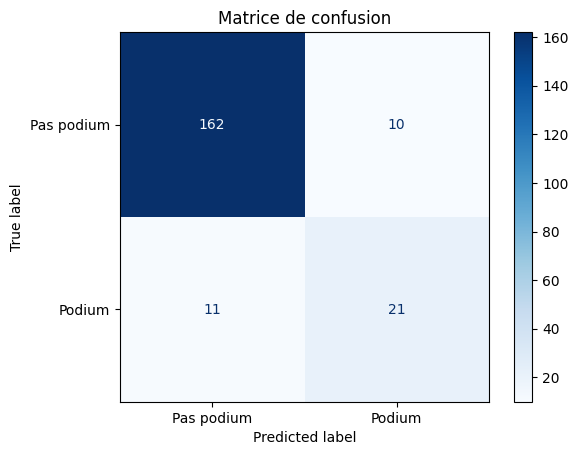

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.94      0.94      0.94       172
      Podium       0.68      0.66      0.67        32

    accuracy                           0.90       204
   macro avg       0.81      0.80      0.80       204
weighted avg       0.90      0.90      0.90       204

                  feature  coefficient
6   ecurie_Alpine F1 Team     0.927092
3         nb_podium_2_ans     0.233438
10         ecurie_McLaren     0.145519
5       ecurie_AlphaTauri    -0.019649
12      ecurie_RB F1 Team    -0.041623
14          ecurie_Sauber    -0.045479
8          ecurie_Ferrari    -0.099315
7     ecurie_Aston Martin    -0.108307
15        ecurie_Williams    -0.109939
4       ecurie_Alfa Romeo    -0.121617
2       nb_victoire_2_ans    -0.124776
9     ecurie_Haas F1 Team    -0.156359
11        ecurie_Mercedes    -0.176753
13        ecurie_Red Bull    -0.229574
0                    grid    -0.326745
1              positi

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder', 'position_fin_saison']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']
# traiter les valeurs manquantes
X = X.fillna(0)


# 4. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")
# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

# Poids des variables
coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_[0]
    }).sort_values(by='coefficient', ascending=False)
print(coef_df)


Une accuracy de 0.88 signifie que 88% des observations testées ont été bien classées. 

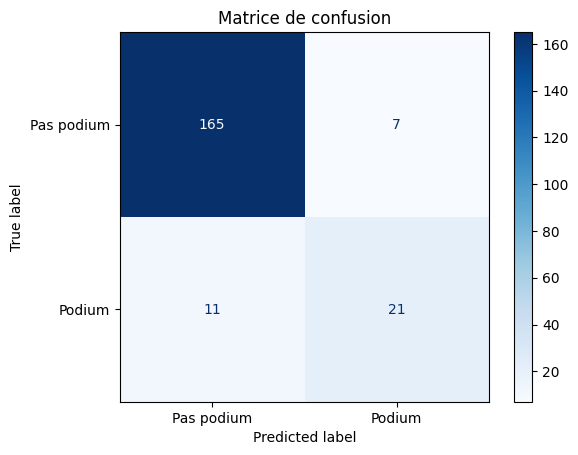

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.94      0.96      0.95       172
      Podium       0.75      0.66      0.70        32

    accuracy                           0.91       204
   macro avg       0.84      0.81      0.82       204
weighted avg       0.91      0.91      0.91       204



In [71]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))


Matrice de confusion : 160 vrais négatifs ; 19 vrais positifs ; 13 faux négatifs ; 12 faux positifs 

Rapport de classification : racall = taux de faux négatifs, le modèle rate des podium ou des non podium, plus il est faible plus le modèle rate ; precision = plus elle est faible plus le modèle prédit à tord ; F1 score = équilibre de ces deux aspects 

Conclusion : pour l'instant le modèle est déséquilibré, il est très bon pour prédire pas podium mais beaucoup moins pour prédire le podium. 



Pistes d'amélioration : tester la régression logistique avec class_weight="balanced", ce qui compense automatiquement le déséquilibre entre les classes.

Accuracy du modèle pour la prédiction du podium : 0.85


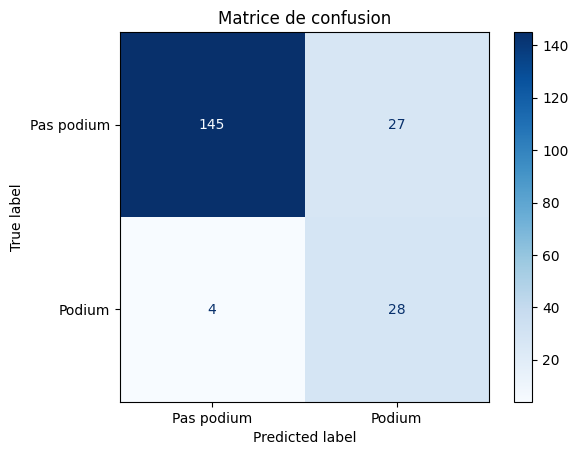

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.97      0.84      0.90       172
      Podium       0.51      0.88      0.64        32

    accuracy                           0.85       204
   macro avg       0.74      0.86      0.77       204
weighted avg       0.90      0.85      0.86       204

                  feature  coefficient
6   ecurie_Alpine F1 Team     1.685897
3         nb_podium_2_ans     0.239560
10         ecurie_McLaren     0.113657
5       ecurie_AlphaTauri    -0.029269
14          ecurie_Sauber    -0.033983
11        ecurie_Mercedes    -0.070750
12      ecurie_RB F1 Team    -0.087823
4       ecurie_Alfa Romeo    -0.090429
2       nb_victoire_2_ans    -0.107247
15        ecurie_Williams    -0.141512
9     ecurie_Haas F1 Team    -0.168123
0                    grid    -0.292455
8          ecurie_Ferrari    -0.315466
7     ecurie_Aston Martin    -0.342288
13        ecurie_Red Bull    -0.449701
1                posi

In [72]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder', 'position_fin_saison']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']
# traiter les valeurs manquantes
X = X.fillna(0)


# 4. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

# Poids des variables
coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_[0]
    }).sort_values(by='coefficient', ascending=False)
print(coef_df)

Accuracy du modèle pour la prédiction du podium : 0.85


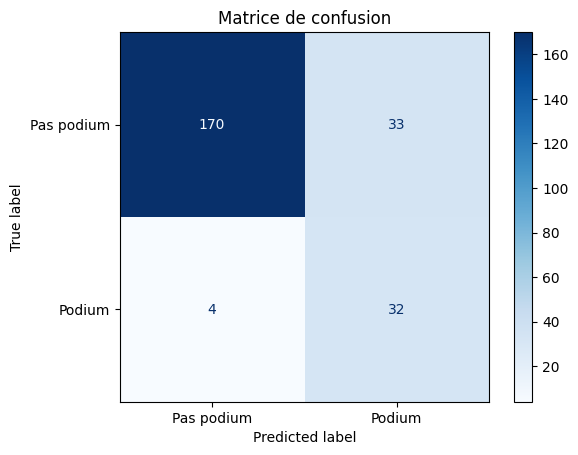

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.98      0.84      0.90       203
      Podium       0.49      0.89      0.63        36

    accuracy                           0.85       239
   macro avg       0.73      0.86      0.77       239
weighted avg       0.90      0.85      0.86       239

17
17


ValueError: All arrays must be of the same length

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
# 4. Séparer les jeux d'entraînement et de test
df_train = df[df['year'] == 2023].copy()
df_test = df[df['year'] == 2024].copy()

# 5. Créer X et y
X_train = df_train.drop(columns=colonnes_a_exclure).fillna(0)
y_train = df_train['sur_podium']

X_test = df_test.drop(columns=colonnes_a_exclure).fillna(0)
y_test = df_test['sur_podium']

# Aligner les colonnes
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))
print(len(X_train.columns))
print(len(model.coef_[0]))

# Poids des variables
coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_[0]
    }).sort_values(by='coefficient', ascending=False)
print(coef_df)